In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the LinearRegression class from scikit-learn's linear_model module
# Also load the PolynomialFeatures transformer and OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

# Load the stats module from scipy so we can code the functions to compute model statistics
from scipy import stats

# Load StatsModels API
# Note that if we wish to use R-style formulas, then we would load statsmodels.formula.api instead
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [49]:
class ExtendedLinearRegression(LinearRegression):
    
    def detailed_linear_regression(self, X, y):
        """
        Assume X is array-like with shape (num_samples, num_features)
        Assume y is array-like with shape (num_samples, num_targets)
        include_intercept is a boolean where True means X does not already have a column
        for the intercept
        Computes the least-squares regression model and returns a dictionary consisting of
        the fitted linear regression object; a series with the residual standard error,
        R^2 value, and the overall F-statistic with corresponding p-value; and a dataframe
        with columns for the parameters, and their corresponding standard errors,
        t-statistics, and p-values.
        """
        # Create a linear regression object and fit it using x and y
        self.training_X, self.training_y = X, y
        self.fit(X, y)
    
        # Store the parameters (regression intercept (if present) and coefficients) and predictions
        if(self.intercept_ != 0):
            self.params = np.append(self.intercept_, self.coef_)
        else:
            self.params = self.coef_.flatten()
        predictions = self.predict(X)
    
        # Create matrix with shape (num_samples, num_features + 1)
        # Where the first column is all 1s (if there is an intercept) and then there is one column for the values
        # of each feature/predictor
        if(self.intercept_ != 0):
            X_mat = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
        else:
            X_mat = X
    
        # Compute residual sum of squares
        self.RSS = np.sum((y - predictions)**2)
    
        # Compute total sum of squares
        self.TSS = np.sum((np.mean(y) - y)**2)
    
        # Estimate the variance of the y-values
        obs_var = self.RSS/(X_mat.shape[0] - X_mat.shape[1])
    
        # Residual standard error is square root of variance of y-values
        self.RSE = obs_var**0.5
    
        # Variances of the parameter estimates are on the diagonal of the 
        # variance-covariance matrix of the parameter estimates
        self.var_beta_mat = obs_var*(np.linalg.inv(np.matmul(X_mat.T, X_mat)))
        self.var_beta = self.var_beta_mat.diagonal()
    
        # Standard error is square root of variance
        self.se_beta = np.sqrt(self.var_beta)
    
        # t-statistic for beta_i is beta_i/se_i, 
        # where se_i is the standard error for beta_i
        t_stats_beta = self.params/self.se_beta
    
        # Compute p-values for each parameter using a t-distribution with
        # (num_samples - 1) degrees of freedom
        beta_p_values = [2 * (1 - stats.t.cdf(np.abs(t_i), X_mat.shape[0] - 1)) for t_i in t_stats_beta]
    
        # Compute value of overall F-statistic, to measure how likely our
        # coefficient estimate are, assuming there is no relationship between
        # the predictors and the response
        if(self.intercept_ != 0):
            self.F_overall = ((self.TSS - self.RSS)/(X_mat.shape[1] - 1))/(self.RSS/(X_mat.shape[0] - X_mat.shape[1]))
            self.F_p_value = stats.f.sf(self.F_overall, X_mat.shape[1] - 1, X_mat.shape[0] - X_mat.shape[1])
        else:
            self.F_overall = ((self.TSS - self.RSS)/(X_mat.shape[1]))/(self.RSS/(X_mat.shape[0] - X_mat.shape[1]))
            self.F_p_value = stats.f.sf(self.F_overall, X_mat.shape[1], X_mat.shape[0] - X_mat.shape[1])
    
        # Construct dataframe for the overall model statistics:
        # RSE, R^2, F-statistic, p-value for F-statistic
        oa_model_stats = pd.Series({"Residual standard error": self.RSE, "R-squared": self.score(X, y), "F-statistic": self.F_overall, "F-test p-value": self.F_p_value})
    
        # Construct dataframe for parameter statistics:
        # coefficients, standard errors, t-statistic, p-values for t-statistics
        param_stats = pd.DataFrame({"Coefficient": self.params, "Standard Error": self.se_beta, "t-value": t_stats_beta, "Prob(>|t|)": beta_p_values})
        return {"model": self, "param_stats": param_stats, "oa_stats": oa_model_stats}
    
    def param_conf_int(self, level = 0.95):
        """
        Assume level, if given, is a float with 0 < level < 1
        Computes confidence intervals at the given confidence level for each parameter
        in the linear regression model relating the predictors X to the response y
        Returns a dataframe with the endpoints of the confidence interval for each parameter
        """
        conf_intervals = pd.DataFrame()
        # Degrees of freedom = num_samples - (num_features + 1)
        df = self.training_X.shape[0] - (self.training_X.shape[1] + 1)
        a, b = str(round((1 - level)*100/2, 2)) + "%", str(round((1 + level)*100/2, 2)) + "%"
        # Loop through each parameter
        for i in range(len(self.params)):
            coeff = self.params[i]
            std_err = self.se_beta[i]
            # alpha = level of confidence
            # df = degrees of freedom = num_samples - number of parameters
            # loc = center of t-interval = estimated coefficient value
            # scale = standard error in coefficient estimate
            conf_intervals = conf_intervals.append(pd.DataFrame([stats.t.interval(level, df, loc = coeff, scale = std_err)], columns = [a, b]), ignore_index = True)
        return conf_intervals
    
    def predict_intervals(self, X_pred, level = 0.95, kind = "confidence"):
        """
        Assume X_pred is array-like with shape (num_predictions, num_features) with x-values for which we want predictions
        Assume level, if given, is a float with 0 < level < 1
        Assume kind, if given is either the string "confidence" or "prediction" for the kind of interval
        Computes confidence intervals at the given confidence level for each parameter
        in the linear regression model relating the predictors X to the response y
        Returns a dataframe with the endpoints of the confidence interval for each parameter
        """
        # Store predictions for easy access
        predictions = self.predict(X_pred)
        intervals = pd.DataFrame()
        # Degrees of freedom = num_samples - (num_features + 1)
        df = self.training_X.shape[0] - (self.training_X.shape[1] + 1)
        a, b = str(round((1 - level)*100/2, 2)) + "%", str(round((1 + level)*100/2, 2)) + "%"
        # Loop through each x-value being used for prediction
        for i in range(len(predictions)):
            prediction = predictions[i]
            # Need to append the leading 1 since our matrix of regression parameter
            # Estimates has first row the estimate for the constant
            x_star = np.append(np.ones(1), X_pred[i])
            conf_error = np.matmul(np.matmul(x_star.T, self.var_beta_mat), x_star)**0.5
            predict_error = (self.RSE**2 + conf_error**2)**0.5
            # alpha = level of confidence
            # df = degrees of freedom = num_samples - number of parameters
            # loc = center of t-interval = predicted value from linear regression model
            # scale = standard error in predicted value estimate
            if (kind == "confidence"):
                lower, upper = stats.t.interval(level, df, loc = prediction, scale = conf_error)
                intervals = intervals.append(pd.Series({"prediction": prediction[0], a: lower[0], b: upper[0]}), ignore_index = True) 
            elif(kind == "prediction"):
                lower, upper = stats.t.interval(level, df, loc = prediction, scale = predict_error)
                intervals = intervals.append(pd.Series({"prediction": prediction[0], a: lower[0], b: upper[0]}), ignore_index = True)
        return intervals


In [50]:
def vif(predictors):
    """
    Assumes predictors is a Pandas dataframe with at least two columns
    Returns a Pandas series containing the variance inflation factor for each column variable
    """
    columns = predictors.columns
    vif_series = pd.Series()
    for col_name in columns:
        X = predictors.drop(columns = [col_name]).values
        y = predictors[col_name].values.reshape(-1, 1)
        reg = LinearRegression().fit(X, y)
        r_sq = reg.score(X, y)
        vif_series[col_name] = 1/(1 - r_sq)
    return vif_series


In [51]:
train_file = "train_ch.csv"
train_dataset = pd.read_csv(train_file, na_values = ["?"]).dropna().drop(columns = ["Unnamed: 0"])
train_dataset.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,Y
0,0.914806,1.014918,35.155085,1.159555,4.831515,0.016446,48.003893,1.483346,1.778322,633.287832
1,0.937075,1.183151,44.488785,1.111901,4.873433,0.006909,48.526829,1.501381,-0.091535,1009.843009
2,0.286140,1.169798,33.157725,1.017829,3.572251,0.015664,33.590482,1.494947,-0.431752,561.693065
3,0.830448,1.018381,36.309150,1.259659,4.649813,0.097736,45.965568,1.500261,0.478378,675.239792
4,0.641746,1.115638,35.925711,1.129575,4.292843,0.039882,41.859772,1.492195,1.406363,660.198867


In [52]:
for column in train_dataset:
    if train_dataset[column].dtype in ['int64', 'float64']:
        Q1 = train_dataset[column].quantile(0.25)
        Q3 = train_dataset[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = train_dataset[(train_dataset[column] < (Q1 - 1.5 * IQR)) | (train_dataset[column] > (Q3 + 1.5 * IQR))]
        # Filter out the outliers
        train_dataset = train_dataset[(train_dataset[column] >= (Q1 - 1.5 * IQR)) & (train_dataset[column] <= (Q3 + 1.5 * IQR))]

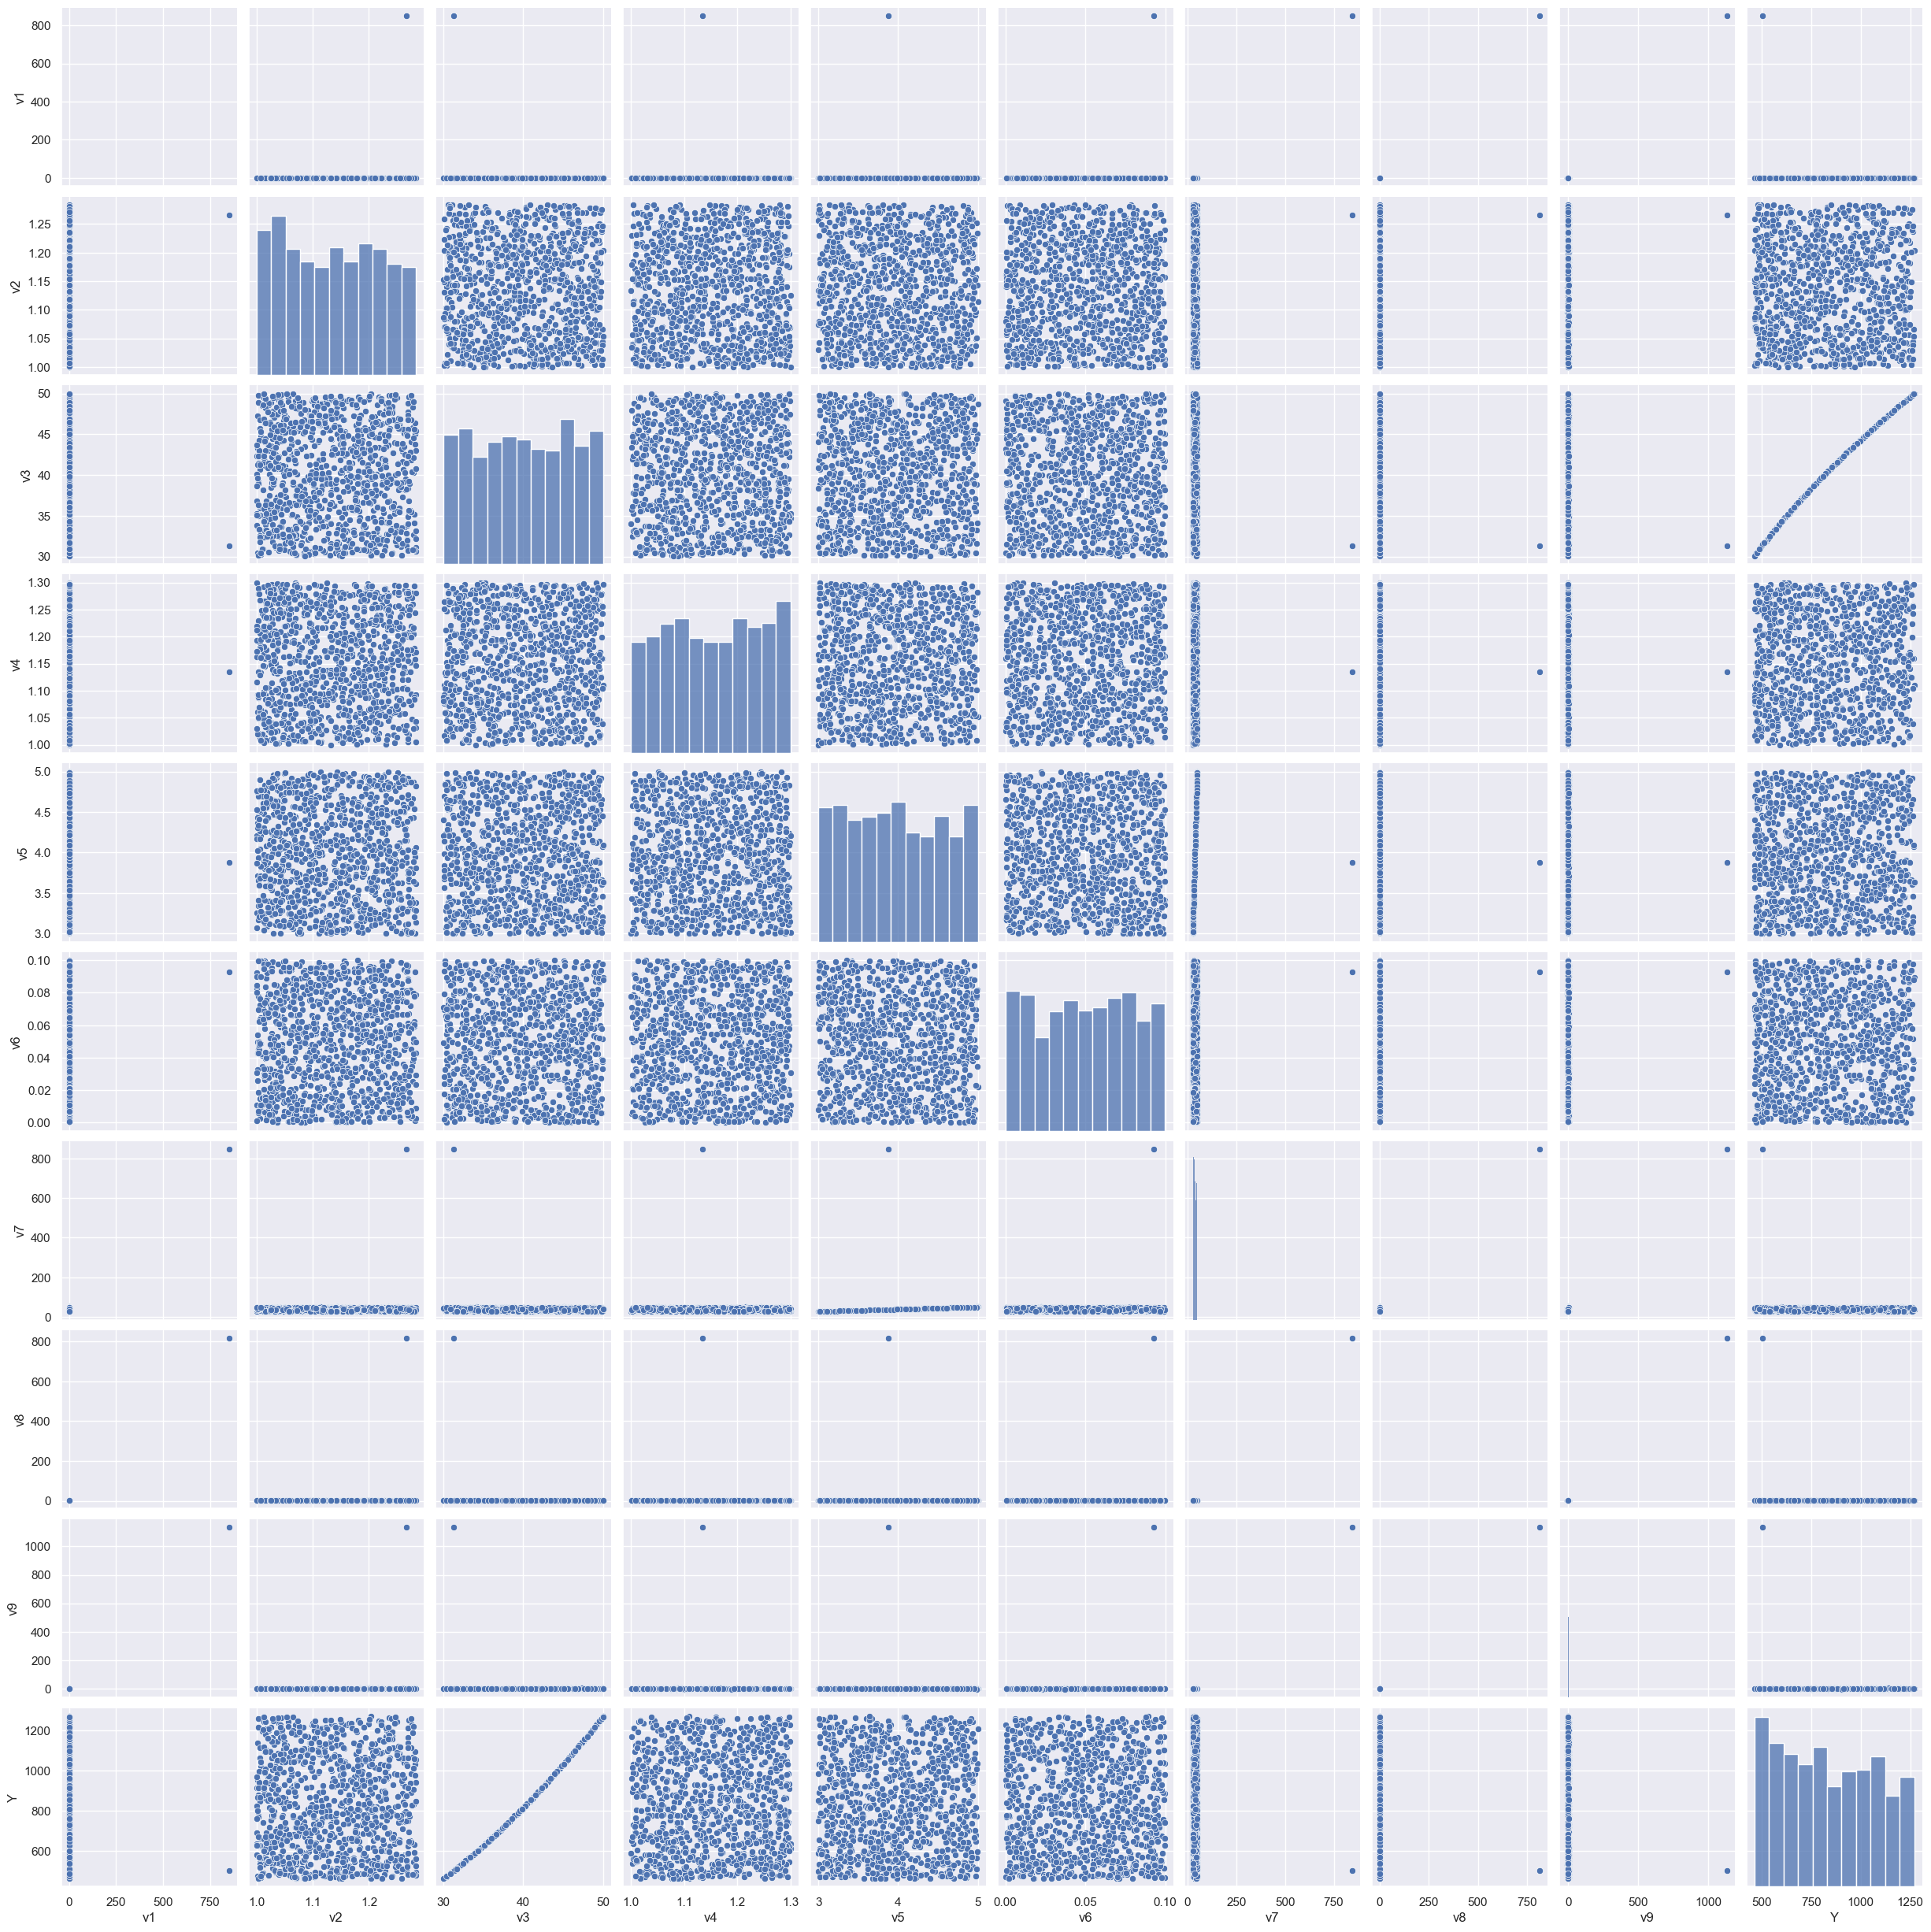

In [12]:
sns.pairplot(train_dataset)

Part 3

In [7]:
# Using R-style formulas in StatsModels
columns = "+".join(train_dataset.columns.drop(["Y"]))
formula = "Y ~ " + columns
mod_all = smf.ols(formula = formula, data = train_dataset)
res_all = mod_all.fit()
print(res_all.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 2.715e+04
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:58:14   Log-Likelihood:                -4065.2
No. Observations:                 987   AIC:                             8150.
Df Residuals:                     977   BIC:                             8199.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1002.2372    207.194     -4.837      0.0

In [8]:
reg_all = ExtendedLinearRegression()

# Encode categorical predictors using OneHotEncoder
# Set the categories and drop the first category when encoding to use reduced-rank coding
# This then replicates the default behavior of how Patsy and R do categorical encoding
X = train_dataset.drop(columns = ["Y"])
y = train_dataset["Y"]
stats_all = reg_all.detailed_linear_regression(X, y)

In [9]:
print(stats_all["param_stats"].set_index(X.columns.insert(0, "intercept")))
np.round(stats_all["oa_stats"], 4)


           Coefficient  Standard Error     t-value  Prob(>|t|)
intercept -1002.237243      207.193845   -4.837196    0.000002
v1          -64.101817      120.515279   -0.531898    0.594917
v2           -3.691869        5.749845   -0.642082    0.520969
v3           40.464117        0.082051  493.157576    0.000000
v4           -5.285299        5.446043   -0.970484    0.332043
v5           52.716898      237.444040    0.222018    0.824346
v6          -15.623598       16.370570   -0.954371    0.340130
v7           -1.648137       23.567892   -0.069931    0.944262
v8           75.055677       93.998104    0.798481    0.424784
v9            0.226390        0.340329    0.665210    0.506072


Residual standard error       14.9534
R-squared                      0.9960
F-statistic                27150.1861
F-test p-value                 0.0000
dtype: float64

In [34]:
v = vif(train_dataset.drop(columns = ["Y"]))
v[v.values > 10].index.values

array(['v1', 'v5', 'v7'], dtype=object)

(0.0, 1.0, 0.0, 1.0)

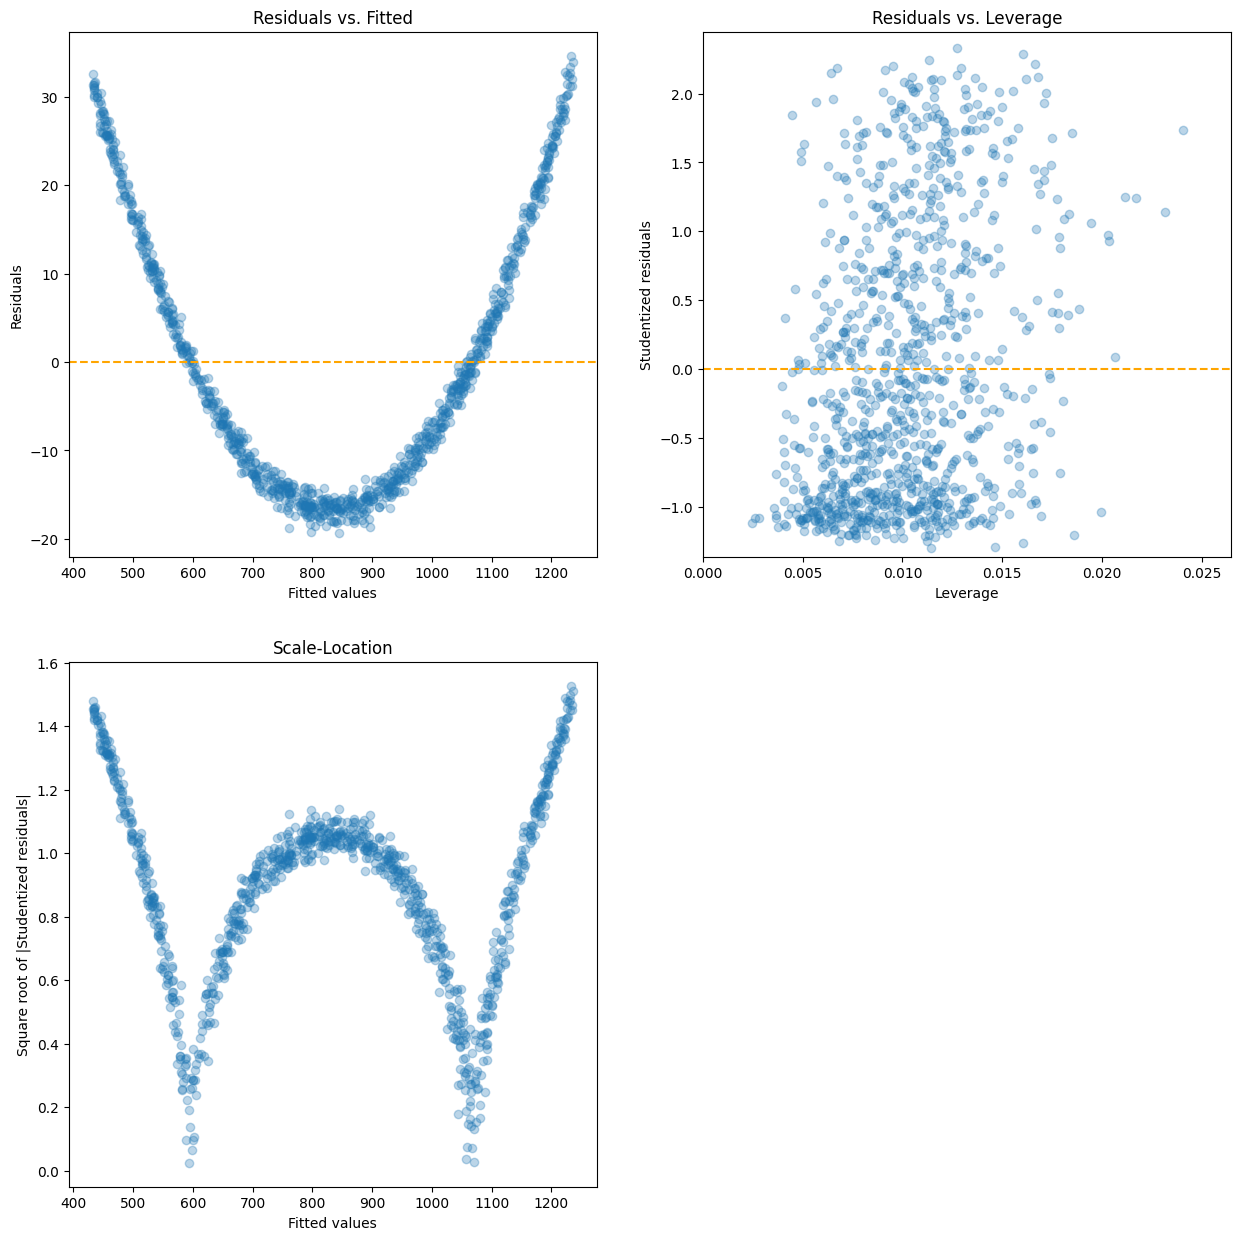

In [11]:

# Compute residuals
predicted_y = reg_all.predict(X)
residuals = (y - predicted_y).values.flatten()

# Compute leverage values, which are the diagonal entries of the hat matrix
design_mat = np.append(np.ones((X.shape[0], 1)), X, axis = 1)
hat_mat = design_mat @ np.linalg.inv(design_mat.T @ design_mat) @ design_mat.T
leverage_vals = hat_mat.diagonal()

# Compute (internally) studentized residuals
residual_standard_error = (np.sum(residuals**2)/(design_mat.shape[0] - design_mat.shape[1]))**0.5
studentized_residuals = residuals/(residual_standard_error*(1 - leverage_vals)**0.5)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 15))
# Plot for residuals vs. fitted value
axes[0, 0].axhline(y = 0, color = "orange", linestyle = "--")
axes[0, 0].scatter(predicted_y, residuals, alpha = 0.3)
axes[0, 0].set(xlabel = "Fitted values", ylabel = "Residuals", title = "Residuals vs. Fitted")
# Scale-location plot
axes[1, 0].scatter(predicted_y, np.abs(studentized_residuals)**0.5, alpha = 0.3)
axes[1, 0].set(xlabel = "Fitted values", ylabel = "Square root of |Studentized residuals|", 
               title = "Scale-Location")
# Residuals vs. Leverage plot
axes[0, 1].axhline(y = 0, color = "orange", linestyle = "--")
axes[0, 1].scatter(leverage_vals, studentized_residuals, alpha = 0.3)
axes[0, 1].set(xlabel = "Leverage", ylabel = "Studentized residuals", title = "Residuals vs. Leverage",
               xlim = (0, leverage_vals.max()*1.1), 
               ylim = (studentized_residuals.min()*1.05, studentized_residuals.max()*1.05))

# Hide the fourth unused subplot
axes[1, 1].axis("off")

In [12]:
# Using ExtendedLinearRegression
poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
# Need to delete the column 8 of interactions, since that is the interaction
# between originEuropean and originJapanese, which originated from the single predictor origin
all_interactions = np.delete(poly.fit_transform(X), 8, axis = 1)
reg_all_interactions = ExtendedLinearRegression()
stats_all_interactions = reg_all_interactions.detailed_linear_regression(all_interactions, y)

In [13]:
np.round(stats_all_interactions["param_stats"], 4)


,Coefficient,Standard Error,t-value,Prob(>|t|)
0,-19974.5020,47602.1040,-0.4196,0.6749
1,-15969.0493,37087.8366,-0.4306,0.6669
2,2531.8055,2675.0719,0.9464,0.3442
3,68.7853,36.0228,1.9095,0.0565
4,2826.0788,2422.8053,1.1664,0.2437
5,1975.5187,70819.7395,0.0279,0.9778
6,-2468.2227,7165.4654,-0.3445,0.7306
7,510.3805,7021.2109,0.0727,0.9421
8,7608.8935,31547.7362,0.2412,0.8095
9,909.0062,1525.6539,0.5958,0.5514


In [14]:
np.round(stats_all_interactions["oa_stats"], 4)

Residual standard error      14.9197
R-squared                     0.9962
F-statistic                5579.4527
F-test p-value                0.0000
dtype: float64

In [15]:
# Using R-style formulas in StatsModels
columns = "+".join(train_dataset.columns.drop(['Y']))
formula = "Y ~ (" + columns + ")**2"
mod_all_interactions = smf.ols(formula = formula, data = train_dataset)
res_all_interactions = mod_all_interactions.fit()
print(res_all_interactions.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     5456.
Date:                Wed, 10 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:58:22   Log-Likelihood:                -4044.4
No. Observations:                 987   AIC:                             8181.
Df Residuals:                     941   BIC:                             8406.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.932e+04   4.76e+04     -0.406      0.6

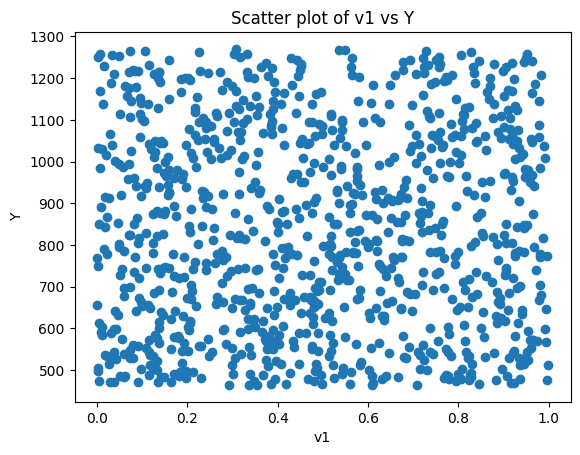

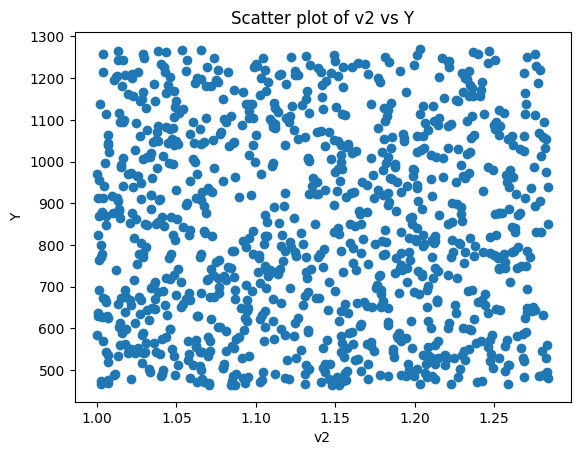

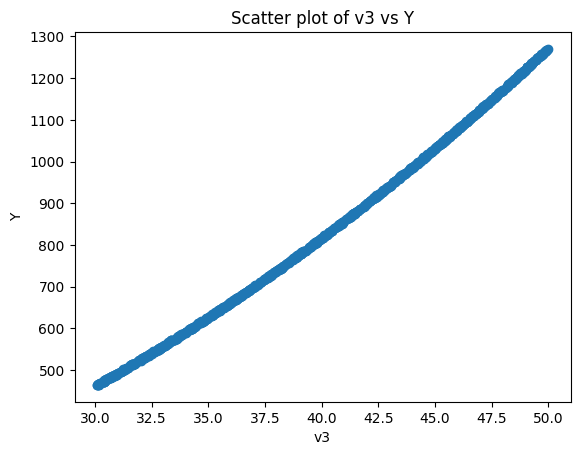

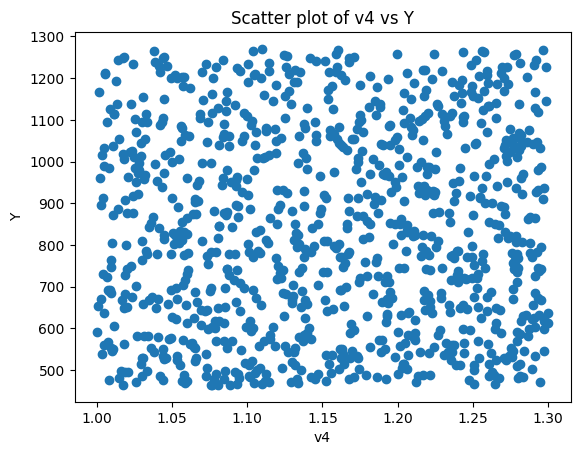

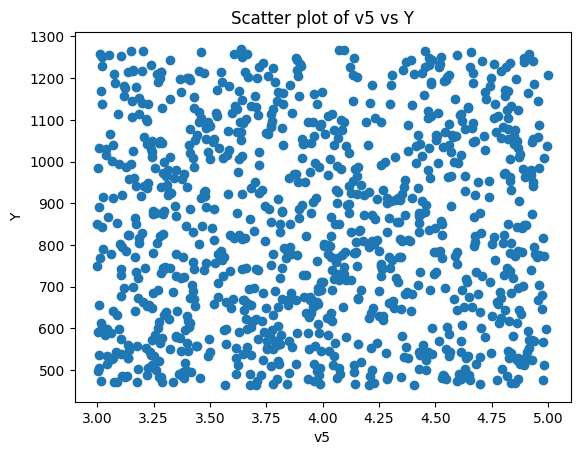

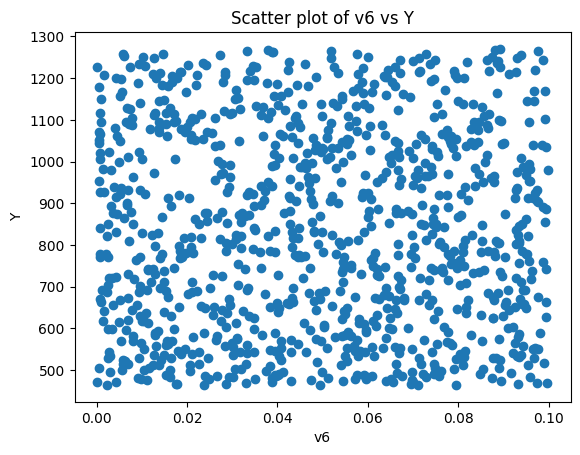

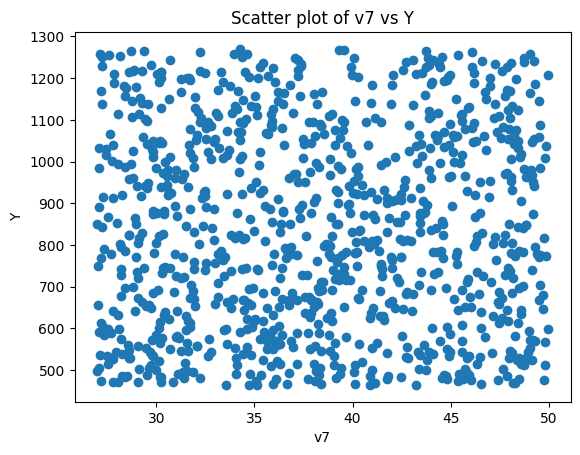

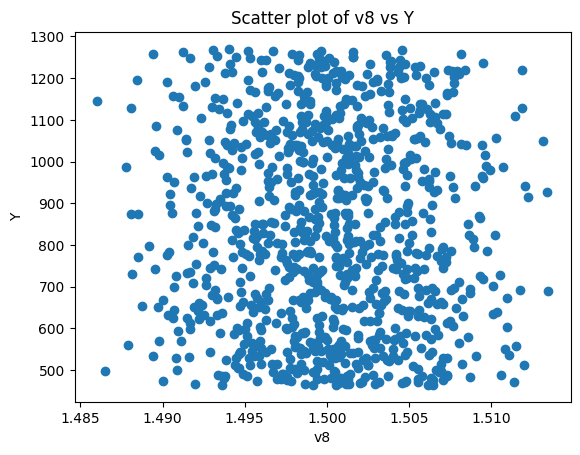

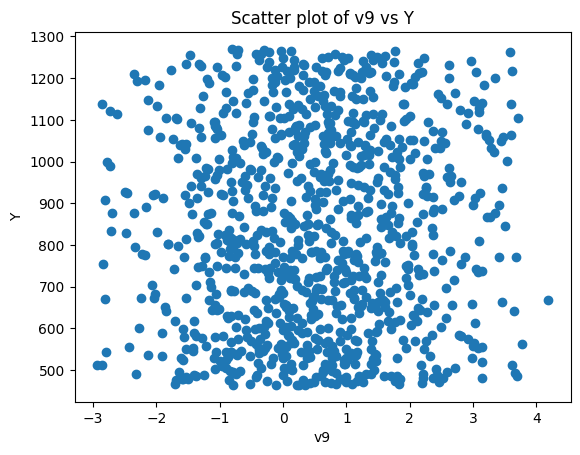

In [16]:
import matplotlib.pyplot as plt

# Iterate over each feature column
for column in train_dataset.columns[:-1]:
    # Create a scatter plot
    plt.scatter(train_dataset[column], train_dataset['Y'])
    plt.xlabel(column)
    plt.ylabel('Y')
    plt.title(f'Scatter plot of {column} vs Y')
    plt.show()


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

rmse_scores = []
r2_scores = []

back_sel_ints = pd.DataFrame({
    "v1:v2": train_dataset["v1"] * train_dataset["v2"],
    "v5:v2": train_dataset["v5"] * train_dataset["v2"],
    "v1:v3": train_dataset["v1"] * train_dataset["v3"],
    "v5:v3": train_dataset["v5"] * train_dataset["v3"],
    "v1:v4": train_dataset["v1"] * train_dataset["v4"],
    "v5:v4": train_dataset["v5"] * train_dataset["v4"],
    "v1:v6": train_dataset["v1"] * train_dataset["v6"],
    "v5:v6": train_dataset["v5"] * train_dataset["v6"],
    "v1:v7": train_dataset["v1"] * train_dataset["v7"],
    "v5:v7": train_dataset["v5"] * train_dataset["v7"],
    "v1:v8": train_dataset["v1"] * train_dataset["v8"],
    "v5:v8": train_dataset["v5"] * train_dataset["v8"],
    "v1:v9": train_dataset["v1"] * train_dataset["v9"],
    "v5:v9": train_dataset["v5"] * train_dataset["v9"],
})

back_sel_X = train_dataset.join(back_sel_ints)

X_train, X_test, y_train, y_test = train_test_split(back_sel_X.drop(columns = ["v1","v5","Y"]), back_sel_X["Y"], test_size=0.2, random_state=42)
back_sel_reg = ExtendedLinearRegression()
back_sel_stats = back_sel_reg.detailed_linear_regression(X_train, y_train)
predictions = back_sel_reg.predict(X_test)
rmse_scores.append(root_mean_squared_error(y_test, predictions))
r2_scores.append(r2_score(y_test, predictions))
# self.plot_predictions(X_test, y_test, predictions)
avg_rmse = sum(rmse_scores) / len(rmse_scores)
avg_r2 = sum(r2_scores) / len(r2_scores)
print(f'Training completed. Average RMSE: {avg_rmse}, Average R2: {avg_r2}')
back_sel_stats

Training completed. Average RMSE: 15.760660036755931, Average R2: 0.9956104712085032


{'model': ExtendedLinearRegression(),
 'param_stats':     Coefficient  Standard Error   t-value  Prob(>|t|)
 0   -560.153306      667.478928 -0.839207    0.401607
 1   1550.911486     1993.881673  0.777835    0.436900
 2     68.789687       27.386286  2.511830    0.012210
 3   3162.520326     1812.079003  1.745244    0.081332
 4  -5648.861542     5279.434600 -1.069975    0.284958
 5      3.876113       28.533296  0.135845    0.891978
 6  -4670.408193     2358.169359 -1.980523    0.047992
 7   -212.338371      112.212723 -1.892284    0.058819
 8   1026.846285     1329.775921  0.772195    0.440230
 9   -516.542599      664.630589 -0.777188    0.437281
 10    18.858386       18.256329  1.032978    0.301931
 11    -9.438568        9.126923 -1.034146    0.301385
 12  2167.990885     1207.424818  1.795549    0.072949
 13 -1062.327509      603.876377 -1.759180    0.078935
 14 -3626.739015     3517.327255 -1.031107    0.302807
 15  1862.354125     1759.182868  1.058647    0.290085
 16     7.57

In [55]:
X_train, X_test, y_train, y_test = train_test_split(train_dataset.drop(columns = ["Y"]), train_dataset["Y"], test_size=0.2, random_state=42)
back_sel_reg = ExtendedLinearRegression()
back_sel_stats = back_sel_reg.detailed_linear_regression(X_train, y_train)
predictions = back_sel_reg.predict(X_test)
rmse_scores.append(root_mean_squared_error(y_test, predictions))
r2_scores.append(r2_score(y_test, predictions))
# self.plot_predictions(X_test, y_test, predictions)
avg_rmse = sum(rmse_scores) / len(rmse_scores)
avg_r2 = sum(r2_scores) / len(r2_scores)
print(f'Training completed. Average RMSE: {avg_rmse}, Average R2: {avg_r2}')
back_sel_stats

Training completed. Average RMSE: 15.652777995320394, Average R2: 0.995516091361844


{'model': ExtendedLinearRegression(),
 'param_stats':    Coefficient  Standard Error     t-value  Prob(>|t|)
 0 -1035.901928      219.641176   -4.716338    0.000003
 1   -71.227425      128.103900   -0.556013    0.578342
 2    -4.102949        6.046398   -0.678577    0.497583
 3    40.472416        0.086108  470.020398    0.000000
 4    -1.203165        5.748997   -0.209283    0.834276
 5   150.020788      251.114637    0.597420    0.550380
 6   -16.213073       17.198193   -0.942720    0.346081
 7    -9.793219       24.852746   -0.394050    0.693639
 8    46.459618       99.277778    0.467976    0.639917
 9     0.374132        0.357003    1.047980    0.294933,
 'oa_stats': Residual standard error       14.923357
 R-squared                      0.996071
 F-statistic                24729.090137
 F-test p-value                 0.000000
 dtype: float64}

In [45]:
vif(train_dataset.drop(columns = ["Y"]))
# lr = LinearRegression()
# lr.fit(train_dataset.drop(columns = ["v1","v3","v5","v7"]), y)

v1       5.207911e+08
v2       2.185325e+05
v3       1.945028e+05
v4       1.993379e+05
v5       7.581384e+09
v6       1.937378e+05
v7       9.862764e+09
v8       1.138196e+05
v9       2.280251e+05
v1_v2    1.156294e+06
v1_v3    2.781534e+05
v1_v4    1.023555e+06
v1_v5    8.632072e+06
v1_v6    3.623608e+04
v1_v7    5.145718e+06
v1_v8    5.120165e+08
v1_v9    2.312281e+04
v2_v3    2.501197e+02
v2_v4    3.755187e+02
v2_v5    2.067728e+07
v2_v6    2.060926e+02
v2_v7    2.524000e+07
v2_v8    9.235703e+04
v2_v9    1.970437e+02
v3_v4    2.413601e+02
v3_v5    8.233320e+06
v3_v6    5.449512e+01
v3_v7    9.144944e+06
v3_v8    9.679805e+04
v3_v9    5.276554e+01
v4_v5    2.029989e+07
v4_v6    1.936747e+02
v4_v7    2.455149e+07
v4_v8    9.364022e+04
v4_v9    1.897306e+02
v5_v6    4.380490e+06
v5_v7    8.542296e+05
v5_v8    7.547656e+09
v5_v9    4.548381e+06
v6_v7    4.120855e+06
v6_v8    9.630673e+04
v6_v9    4.342178e+00
v7_v8    9.804138e+09
v7_v9    4.200611e+06
v8_v9    1.010270e+05
dtype: flo

{'model': ExtendedLinearRegression(),
 'param_stats':    Coefficient  Standard Error     t-value    Prob(>|t|)
 0  -803.372725      154.921462   -5.185677  2.738498e-07
 1    -1.890185        6.281414   -0.300917  7.635570e-01
 2    40.459482        0.090569  446.726044  0.000000e+00
 3    -2.704688        5.949213   -0.454629  6.495010e-01
 4   -10.776216       18.043852   -0.597224  5.505296e-01
 5     0.162661        0.077942    2.086942  3.721420e-02
 6    11.781373      102.824081    0.114578  9.088088e-01
 7     0.212881        0.372277    0.571834  5.675974e-01,
 'oa_stats': Residual standard error       14.727774
 R-squared                      0.996119
 F-statistic                28637.868922
 F-test p-value                 0.000000
 dtype: float64}
